In [3]:
from imutils.perspective import four_point_transform
import matplotlib.pyplot as plt
import pytesseract
import imutils
import cv2
import re
import requests
import numpy as np

In [14]:
def plt_imshow(title="image", img=None, figsize=(8,5)):
    plt.figure(figsize=figsize)
    
    if type(img) == list:
        if type(title) == list:
            titles = title
        else :
            titles=[]
            
            for i in range(len(img)):
                titles.append(title)
                
        for i in range(len(img)):
            if len(img[i].shape) <= 2:
                rgbimg = cv2.cvtColor(img[i], cv2.COLOR_GRAY2RGB)
            else:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_BGR2RGB)
                
            plt.subplot(1, lem(img), i+1), plt.imshow(rgbImg)
            plt.title(titles[i])
            plt.xticks([]), plt.yticks([])
        
        plt.show()
    else:
        if len(img.shape) < 3:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        else :
            rgbImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        plt.imshow(rgbImg)
        plt.title(title)
        plt.xticks([]), plt.yticks([])
        plt.show()

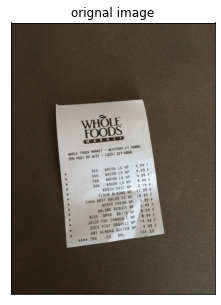

In [15]:
url = 'https://user-images.githubusercontent.com/69428232/148330274-237d9b23-4a79-4416-8ef1-bb7b2b52edc4.jpg'
 
image_nparray = np.asarray(bytearray(requests.get(url).content), dtype=np.uint8)
org_image = cv2.imdecode(image_nparray, cv2.IMREAD_COLOR) 
 
plt_imshow("orignal image", org_image)